<a href="https://colab.research.google.com/github/Pacharaponarp/Tuberculosis-Covid-19-Classification/blob/main/Tuberculosis(Shenzhen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import os, warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
def set_seed(seed=12345):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! kaggle datasets download raddar/tuberculosis-chest-xrays-shenzhen

100% 3.51G/3.51G [01:30<00:00, 74.1MB/s]
100% 3.51G/3.51G [01:30<00:00, 41.8MB/s]


In [4]:
! unzip tuberculosis-chest-xrays-shenzhen.zip

Archive:  tuberculosis-chest-xrays-shenzhen.zip
  inflating: images/images/CHNCXR_0001_0.png  
  inflating: images/images/CHNCXR_0002_0.png  
  inflating: images/images/CHNCXR_0003_0.png  
  inflating: images/images/CHNCXR_0004_0.png  
  inflating: images/images/CHNCXR_0005_0.png  
  inflating: images/images/CHNCXR_0006_0.png  
  inflating: images/images/CHNCXR_0007_0.png  
  inflating: images/images/CHNCXR_0008_0.png  
  inflating: images/images/CHNCXR_0009_0.png  
  inflating: images/images/CHNCXR_0010_0.png  
  inflating: images/images/CHNCXR_0011_0.png  
  inflating: images/images/CHNCXR_0012_0.png  
  inflating: images/images/CHNCXR_0013_0.png  
  inflating: images/images/CHNCXR_0014_0.png  
  inflating: images/images/CHNCXR_0015_0.png  
  inflating: images/images/CHNCXR_0016_0.png  
  inflating: images/images/CHNCXR_0017_0.png  
  inflating: images/images/CHNCXR_0018_0.png  
  inflating: images/images/CHNCXR_0019_0.png  
  inflating: images/images/CHNCXR_0020_0.png  
  inflating:

In [5]:
train_path = os.path.join('/kaggle/temp','train')
val_path = os.path.join('/kaggle/temp','val')
test_path = os.path.join('/kaggle/temp','test')
os.makedirs(train_path)
os.makedirs(val_path)
os.makedirs(test_path)
os.makedirs(os.path.join('/kaggle/temp/train','normal'))
os.makedirs(os.path.join('/kaggle/temp/train','tb'))
os.makedirs(os.path.join('/kaggle/temp/val','normal'))
os.makedirs(os.path.join('/kaggle/temp/val','tb'))
os.makedirs(os.path.join('/kaggle/temp/test','normal'))
os.makedirs(os.path.join('/kaggle/temp/test','tb'))

In [6]:
os.listdir("/kaggle/temp/test/")

['normal', 'tb']

In [11]:
from shutil import copyfile
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/shenzhen_metadata.csv')
#data.head()
data.findings.loc[data.findings != 'normal'] = 'tb'
df_train_val,df_test = train_test_split(data,test_size = 0.1, random_state = 1,stratify = data.findings )
df_train,df_val = train_test_split(df_train_val,test_size = 0.1/0.9, random_state = 1,stratify = df_train_val.findings)

df_train_image = df_train.loc[:,['study_id','findings']]
df_val_image = df_val.loc[:,['study_id','findings']]
df_test_image = df_test.loc[:,['study_id','findings']]

df_train_image.set_index('study_id')
df_val_image.set_index('study_id')
df_test_image.set_index('study_id')

for sid in list(df_train_image.study_id):
    finding = df_train_image.findings.loc[sid == df_train_image.study_id]
    source = os.path.join('/content/images/images/',sid)
    target = os.path.join('/kaggle/temp/train/',finding.iloc[0]+'/'+sid)
    copyfile(source,target)
for sid in list(df_val_image.study_id):
    finding = df_val_image.findings.loc[sid == df_val_image.study_id]
    source = os.path.join('/content/images/images/',sid)
    target = os.path.join('/kaggle/temp/val/',finding.iloc[0]+'/'+sid)
    copyfile(source,target)
for sid in list(df_test_image.study_id):
    finding = df_test_image.findings.loc[sid == df_test_image.study_id]
    source = os.path.join('/content/images/images/',sid)
    target = os.path.join('/kaggle/temp/test/',finding.iloc[0]+'/'+sid)
    copyfile(source,target)

In [12]:
print(len(os.listdir('/kaggle/temp/train/normal')))
print(len(os.listdir('/kaggle/temp/train/tb')))
print(len(os.listdir('/kaggle/temp/val/normal')))
print(len(os.listdir('/kaggle/temp/val/tb')))
print(len(os.listdir('/kaggle/temp/test/normal')))
print(len(os.listdir('/kaggle/temp/test/tb')))

260
268
33
34
33
34


In [16]:
ds_train_image_ = image_dataset_from_directory(
    '/kaggle/temp/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_val_image_ = image_dataset_from_directory(
    '/kaggle/temp/val',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_test_image_ = image_dataset_from_directory(
    '/kaggle/temp/test',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train_image = (
    ds_train_image_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val_image = (
    ds_val_image_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test_image = (
    ds_test_image_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 528 files belonging to 2 classes.
Found 67 files belonging to 2 classes.
Found 67 files belonging to 2 classes.


In [75]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
)
pretrained_model.trainable = False

model =keras.Sequential([
    layers.InputLayer(input_shape=(128, 128,3)),
    #preprocessing.RandomContrast(0.2),
    preprocessing.RandomFlip(mode = "horizontal"),
    #preprocessing.RandomWidth(factor=0.10),
    #preprocessing.RandomRotation(factor=0.05),
    #preprocessing.RandomTranslation(height_factor = 0.05,width_factor=0.05),
    pretrained_model,
    
    layers.Flatten(),
    layers.BatchNormalization(renorm=True),
    layers.Dense(units = 16, activation = 'relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(units = 1,activation = 'sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.005,
    restore_best_weights=True,
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_18 (RandomFlip)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_18 (Flatten)        (None, 32768)             0         
                                                                 
 batch_normalization_20 (Bat  (None, 32768)            229376    
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 16)                524304    
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                     

In [76]:
history = model.fit(
    ds_train_image,
    validation_data=ds_val_image,
    epochs=100,
    #callbacks=[early_stopping],
    callbacks = [reduce_lr]
)

Epoch 1/100
9/9 [==============================] - 6s 239ms/step - loss: 0.6965 - binary_accuracy: 0.5000 - val_loss: 0.6873 - val_binary_accuracy: 0.5075 - lr: 3.0000e-04
Epoch 2/100
9/9 [==============================] - 1s 110ms/step - loss: 0.6901 - binary_accuracy: 0.5246 - val_loss: 0.6830 - val_binary_accuracy: 0.7612 - lr: 3.0000e-04
Epoch 3/100
9/9 [==============================] - 1s 108ms/step - loss: 0.6843 - binary_accuracy: 0.5587 - val_loss: 0.6783 - val_binary_accuracy: 0.7761 - lr: 3.0000e-04
Epoch 4/100
9/9 [==============================] - 1s 110ms/step - loss: 0.6788 - binary_accuracy: 0.5928 - val_loss: 0.6741 - val_binary_accuracy: 0.6866 - lr: 3.0000e-04
Epoch 5/100
9/9 [==============================] - 1s 108ms/step - loss: 0.6731 - binary_accuracy: 0.5985 - val_loss: 0.6669 - val_binary_accuracy: 0.6716 - lr: 3.0000e-04
Epoch 6/100
9/9 [==============================] - 1s 109ms/step - loss: 0.6679 - binary_accuracy: 0.5720 - val_loss: 0.6599 - val_binary_ac

best


binary_accuracy        0.821970
val_binary_accuracy    0.865672
dtype: float64

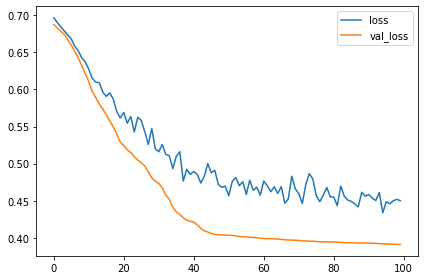

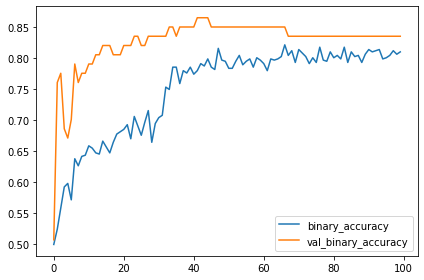

In [77]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print('best')
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].max()

In [78]:
results_val = model.evaluate(ds_val_image, verbose=0)
print("    Val Loss: {:.5f}".format(results_val[0]))
print("Val Accuracy: {:.2f}%".format(results_val[1] * 100))

    Val Loss: 0.39121
Val Accuracy: 83.58%


In [79]:
results = model.evaluate(ds_test_image, verbose=0)

In [80]:
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.36673
Test Accuracy: 85.07%
